In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import os
from tqdm.notebook import tqdm
from pathlib import Path
import shutil


from music_plots import *
import numpy as np

In [2]:
files = os.listdir('data/spectrograms')
tracks_df = load("data/tracks.csv")
genres_df = load("data/genres.csv")

In [3]:
track_ids = []
print(files)
for file in tqdm(files):
    pre, ext = os.path.splitext(file)
    track_ids.append(int(pre))

['98236.png', '18350.png', '93363.png', '98550.png', '46238.png', '75194.png', '68853.png', '97887.png', '38902.png', '98578.png', '14542.png', '55293.png', '37416.png', '27611.png', '67235.png', '55287.png', '67553.png', '27177.png', '90695.png', '97844.png', '70775.png', '14581.png', '72604.png', '61491.png', '26902.png', '81565.png', '15476.png', '75396.png', '87100.png', '39188.png', '18146.png', '63292.png', '53379.png', '96743.png', '34484.png', '94632.png', '59654.png', '11638.png', '14740.png', '13749.png', '61452.png', '60994.png', '75427.png', '44822.png', '69768.png', '71133.png', '75433.png', '63251.png', '60758.png', '64516.png', '39605.png', '20432.png', '136091.png', '114556.png', '124481.png', '112133.png', '127188.png', '131932.png', '123488.png', '145043.png', '104779.png', '147126.png', '122999.png', '126241.png', '135229.png', '142089.png', '136708.png', '125774.png', '133102.png', '141594.png', '132793.png', '132787.png', '109711.png', '138282.png', '108341.png', '

  0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
#tracks_df.columns = pd.MultiIndex.from_product([['track'],['id']])
filtered_tracks = tracks_df.xs('track', level=0, axis=1)['genre_top'].loc[track_ids]
filtered_tracks

track_id
98236     Instrumental
18350             Folk
93363       Electronic
98550          Hip-Hop
46238     Experimental
             ...      
4779              Rock
6608           Hip-Hop
6393     International
4235     International
1417              Rock
Name: genre_top, Length: 100, dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

Some tracks don't have a genre

In [5]:
filtered_tracks.isna().any()

False

Check all top level genres

In [6]:
filtered_tracks.unique()

['Instrumental', 'Folk', 'Electronic', 'Hip-Hop', 'Experimental', 'Pop', 'Rock', 'International']
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

In [7]:
filtered_tracks.loc[4037]

'Folk'

Generate directories

In [8]:
Path("dataset").mkdir(parents=True, exist_ok=True)

for genres in tqdm(filtered_tracks.unique()):
    Path("dataset/"+genres).mkdir(parents=True, exist_ok=True)

for track_id in tqdm(filtered_tracks.index):
    shutil.copyfile('data/spectrograms/' + str(track_id) + ".png", "dataset/" + filtered_tracks.loc[track_id] + "/" + str(track_id) + ".png")

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
image_size = (600, 200)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 100 files belonging to 8 classes.
Using 80 files for training.
Metal device set to: Apple M1 Pro
Found 100 files belonging to 8 classes.
Using 20 files for validation.


2022-06-15 16:03:16.894615: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-15 16:03:16.894743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022-06-15 16:03:16.948225: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


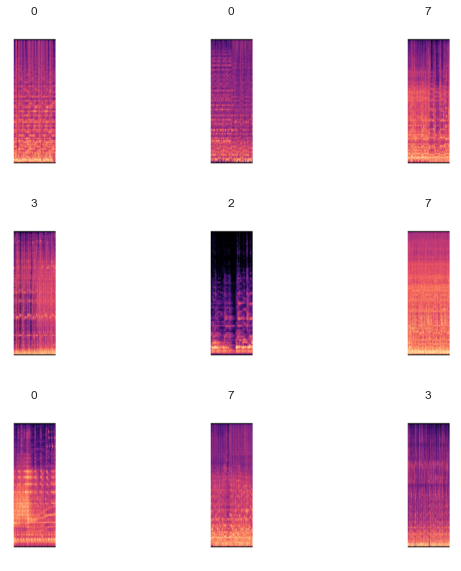

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [11]:
#with tf.device('/cpu:0'):
#    data_augmentation = keras.Sequential(
#        [
#            layers.RandomFlip("horizontal"),
#            layers.RandomRotation(0.1),
#        ]
#    )

In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

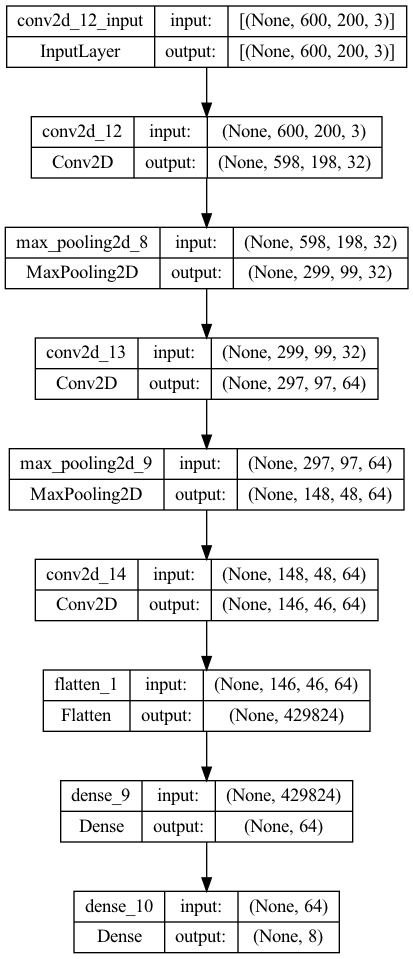

In [31]:
def make_model(input_shape, num_classes):
        # Create model here
    	# create model
        layers.Rescaling(1./255, input_shape=(200, 600, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        # Compile model
        model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        return model


model = make_model(input_shape=image_size + (3,), num_classes=8)
keras.utils.plot_model(model, show_shapes=True)

In [32]:
epochs = 50
tf.device('/CPU')
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


2022-06-15 16:26:47.444096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: -15.2108 - accuracy: 0.1250

2022-06-15 16:26:48.653404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 560ms/step - loss: -15.2108 - accuracy: 0.1250 - val_loss: -20.0229 - val_accuracy: 0.1500
Epoch 2/50
3/3 [==============================] - 1s 518ms/step - loss: -15.2108 - accuracy: 0.1250 - val_loss: -20.0229 - val_accuracy: 0.1500
Epoch 3/50
3/3 [==============================] - 1s 509ms/step - loss: -15.2108 - accuracy: 0.1250 - val_loss: -20.0229 - val_accuracy: 0.1500
Epoch 4/50
3/3 [==============================] - 1s 526ms/step - loss: -15.2108 - accuracy: 0.1250 - val_loss: -20.0229 - val_accuracy: 0.1500
Epoch 5/50
3/3 [==============================] - 1s 500ms/step - loss: -15.2108 - accuracy: 0.1250 - val_loss: -20.0229 - val_accuracy: 0.1500
Epoch 6/50
3/3 [==============================] - 1s 512ms/step - loss: -15.2108 - accuracy: 0.1250 - val_loss: -20.0229 - val_accuracy: 0.1500
Epoch 7/50
3/3 [==============================] - 1s 505ms/step - loss: -15.2108 - accuracy: 0.1250 - val_loss: -20.0229 - val_accuracy: 0.1500
Epo

In [30]:
img = tf.keras.preprocessing.image.load_img(
    "dataset/Hip-Hop/6608.png", target_size=image_size
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
predictions

1/1 [==============================] - 0s 49ms/step


2022-06-15 16:25:29.059397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 42633.96 , 116811.92 ,  48157.49 , -53267.094,  60617.836,
        194816.9  , -48143.87 ,    513.626]], dtype=float32)